In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from matplotlib import cm

In [2]:
covid_preds_resampled = np.load("../../output/exp_covid/smc_t/smc_t_d32_p60/1/resampled_particles_preds_test.npy")

In [3]:
synthetic_1_preds_resampled = np.load("../../output/exp_synthetic_model_1/smc_t/smc_t_d16_p10/1/resampled_particles_preds_test.npy")

In [4]:
covid_preds_resampled.shape

(89, 60, 60, 1)

In [5]:
covid_truth = np.load("../../data/covid/test/covid.npy")
covid_truth = covid_truth[:,:-1,:]
covid_truth.shape

(89, 60, 1)

In [6]:
synthetic_truth = np.load("../../data/synthetic_model_1/test/synthetic.npy")
synthetic_truth = synthetic_truth[:,:-1,:]
synthetic_truth.shape

(100, 24, 1)

In [7]:
def get_unique_arrays(array, index):
    array = np.squeeze(array)
    list_unique_arrays = []
    list_indexes = []
    list_counts = []
    arr = array[index]
    num_timesteps = array.shape[2]
    for t in range(num_timesteps):
        unique_arr, indexes, counts = np.unique(arr[:,t], return_index=True, return_counts=True)
        list_unique_arrays.append(unique_arr)
        list_indexes.append(indexes)
        list_counts.append(counts)
    return list_unique_arrays, list_indexes, list_counts

In [8]:
#index = np.random.randint(0,covid_preds_resampled.shape[0])
#covid_unique_array, covid_indexes, covid_counts = get_unique_arrays(covid_preds_resampled, index)
#covid_num_particles = [arr.shape[0] for arr in covid_unique_array]

In [9]:
#index = np.random.randint(0,synthetic_1_preds_resampled.shape[0])
#synthetic_unique_array, synthetic_indexes, synthetic_counts = get_unique_arrays(synthetic_1_preds_resampled, index)
#synthetic_num_particles = [arr.shape[0] for arr in synthetic_unique_array]

In [10]:
def plot_resampled_particles(array, truth=None, factor=1.5):
    index = np.random.randint(0,array.shape[0])
    unique_arr, indexes, counts = get_unique_arrays(array, index)
    num_unique_particles = [arr.shape[0] for arr in unique_arr]
    evenly_spaced_interval = np.linspace(0, 1, unique_arr[-1].shape[0])
    colors = [cm.rainbow(x) for x in evenly_spaced_interval]
    fig, ax = plt.subplots(figsize=(15, 7))
    x = np.linspace(1,len(unique_arr),len(unique_arr))
    ax2 = ax.twinx() 
    ax2.set_ylabel('number of unique particles', color='grey')
    for t in range(len(unique_arr)):
        num_p = unique_arr[t].shape[0]
        for index, col in enumerate(colors[:num_p]):
            ax.scatter(t+1,unique_arr[t][index], c=col, s=(counts[t][index])**factor, alpha=0.5)
    #ax2.scatter(x, num_unique_particles, color='grey', alpha=0.7, marker='_', linewidth=4)
    #ax2.plot(x, num_unique_particles, color='grey', alpha=0.7)
    if truth is not None:
        truth = np.squeeze(truth[index])
        ax.scatter(x, truth, color='black', marker='x', linewidth=3)
    ax2.bar(x, num_unique_particles, color='grey', alpha=0.1)
    ax2.tick_params(axis='y', labelcolor='grey')
    fig.tight_layout()
    plt.show()

In [11]:
def plot_resampled_particles_multiple(array, truth, factor=1.5):
    fig, axes = plt.subplots(2,2,figsize=(30, 15))
    evenly_spaced_interval = np.linspace(0, 1, array.shape[2])
    colors = [cm.rainbow(x) for x in evenly_spaced_interval]
    x = np.linspace(1,array.shape[2],array.shape[2])
    for i in range(2):
        for j in range(2):
            ax = axes[i][j]
            index = np.random.randint(0,array.shape[0])
            truth_i = np.squeeze(truth[index])
            unique_arr, indexes, counts = get_unique_arrays(array, index)
            num_unique_particles = [arr.shape[0] for arr in unique_arr]
            #evenly_spaced_interval = np.linspace(0, 1, unique_arr[-1].shape[0])
            #colors = [cm.rainbow(x) for x in evenly_spaced_interval]
            #x = np.linspace(1,len(unique_arr),len(unique_arr))
            ax2 = ax.twinx() 
            ax2.set_ylabel('number of unique particles', color='grey')
            for t in range(len(unique_arr)):
                num_p = unique_arr[t].shape[0]
                for index, col in enumerate(colors[:num_p]):
                    ax.scatter(t+1,unique_arr[t][index], c=col, s=(counts[t][index])**factor, alpha=0.5)
            #ax2.scatter(x, num_unique_particles, color='grey', alpha=0.7, marker='_', linewidth=4)
            #ax2.plot(x, num_unique_particles, color='grey', alpha=0.7)
            ax.scatter(x, truth_i, color='black', marker='x', linewidth=3)
            ax2.bar(x, num_unique_particles, color='grey', alpha=0.1)
            ax2.tick_params(axis='y', labelcolor='grey')
    fig.tight_layout()

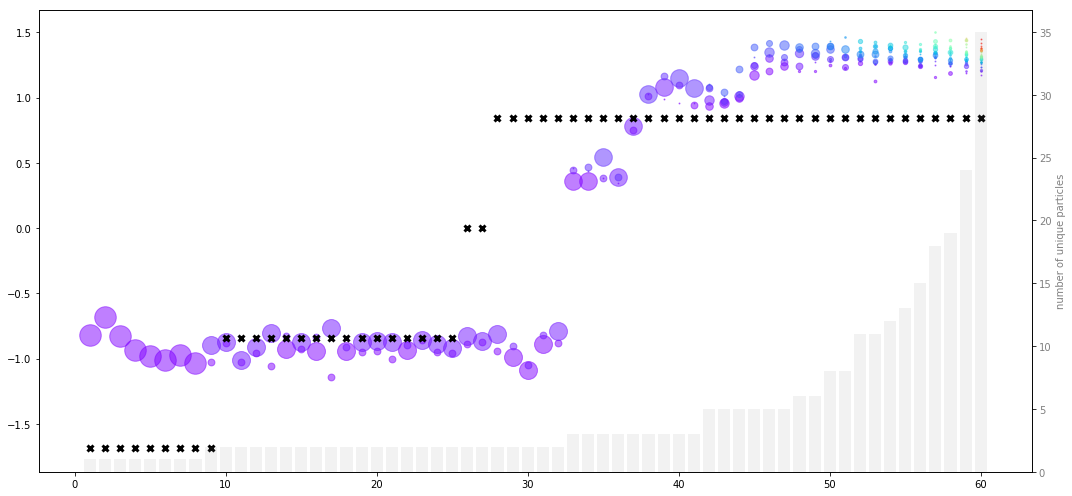

In [12]:
plot_resampled_particles(covid_preds_resampled, covid_truth)

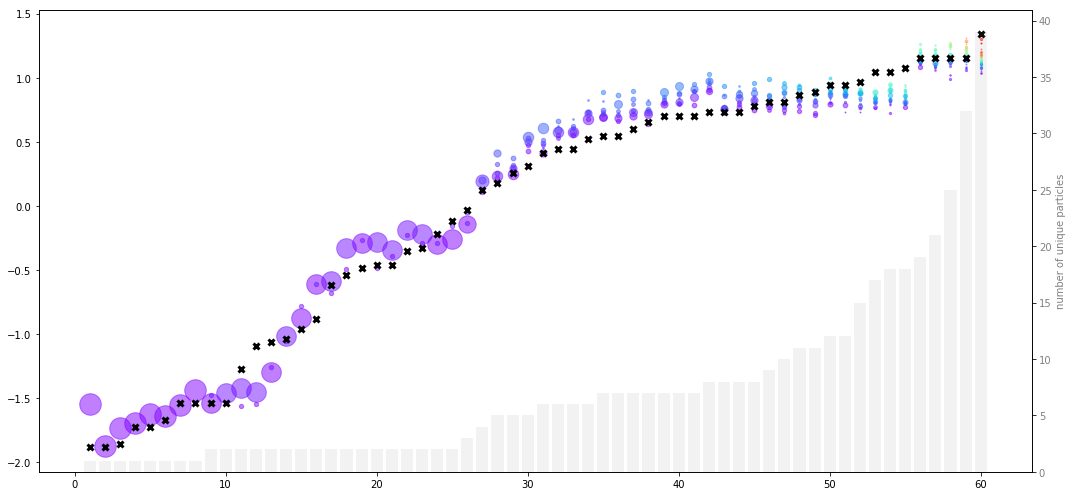

In [16]:
plot_resampled_particles(covid_preds_resampled, covid_truth)

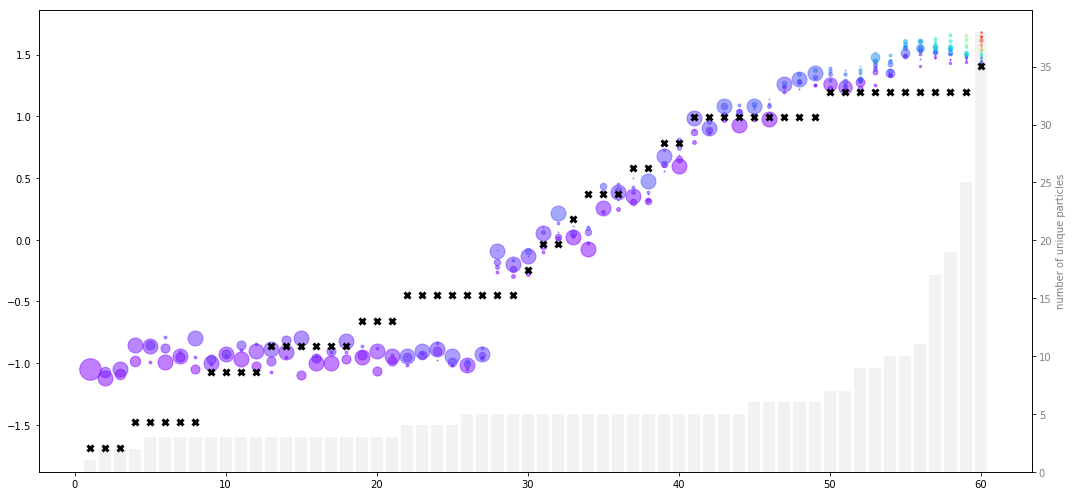

In [18]:
plot_resampled_particles(covid_preds_resampled, covid_truth)

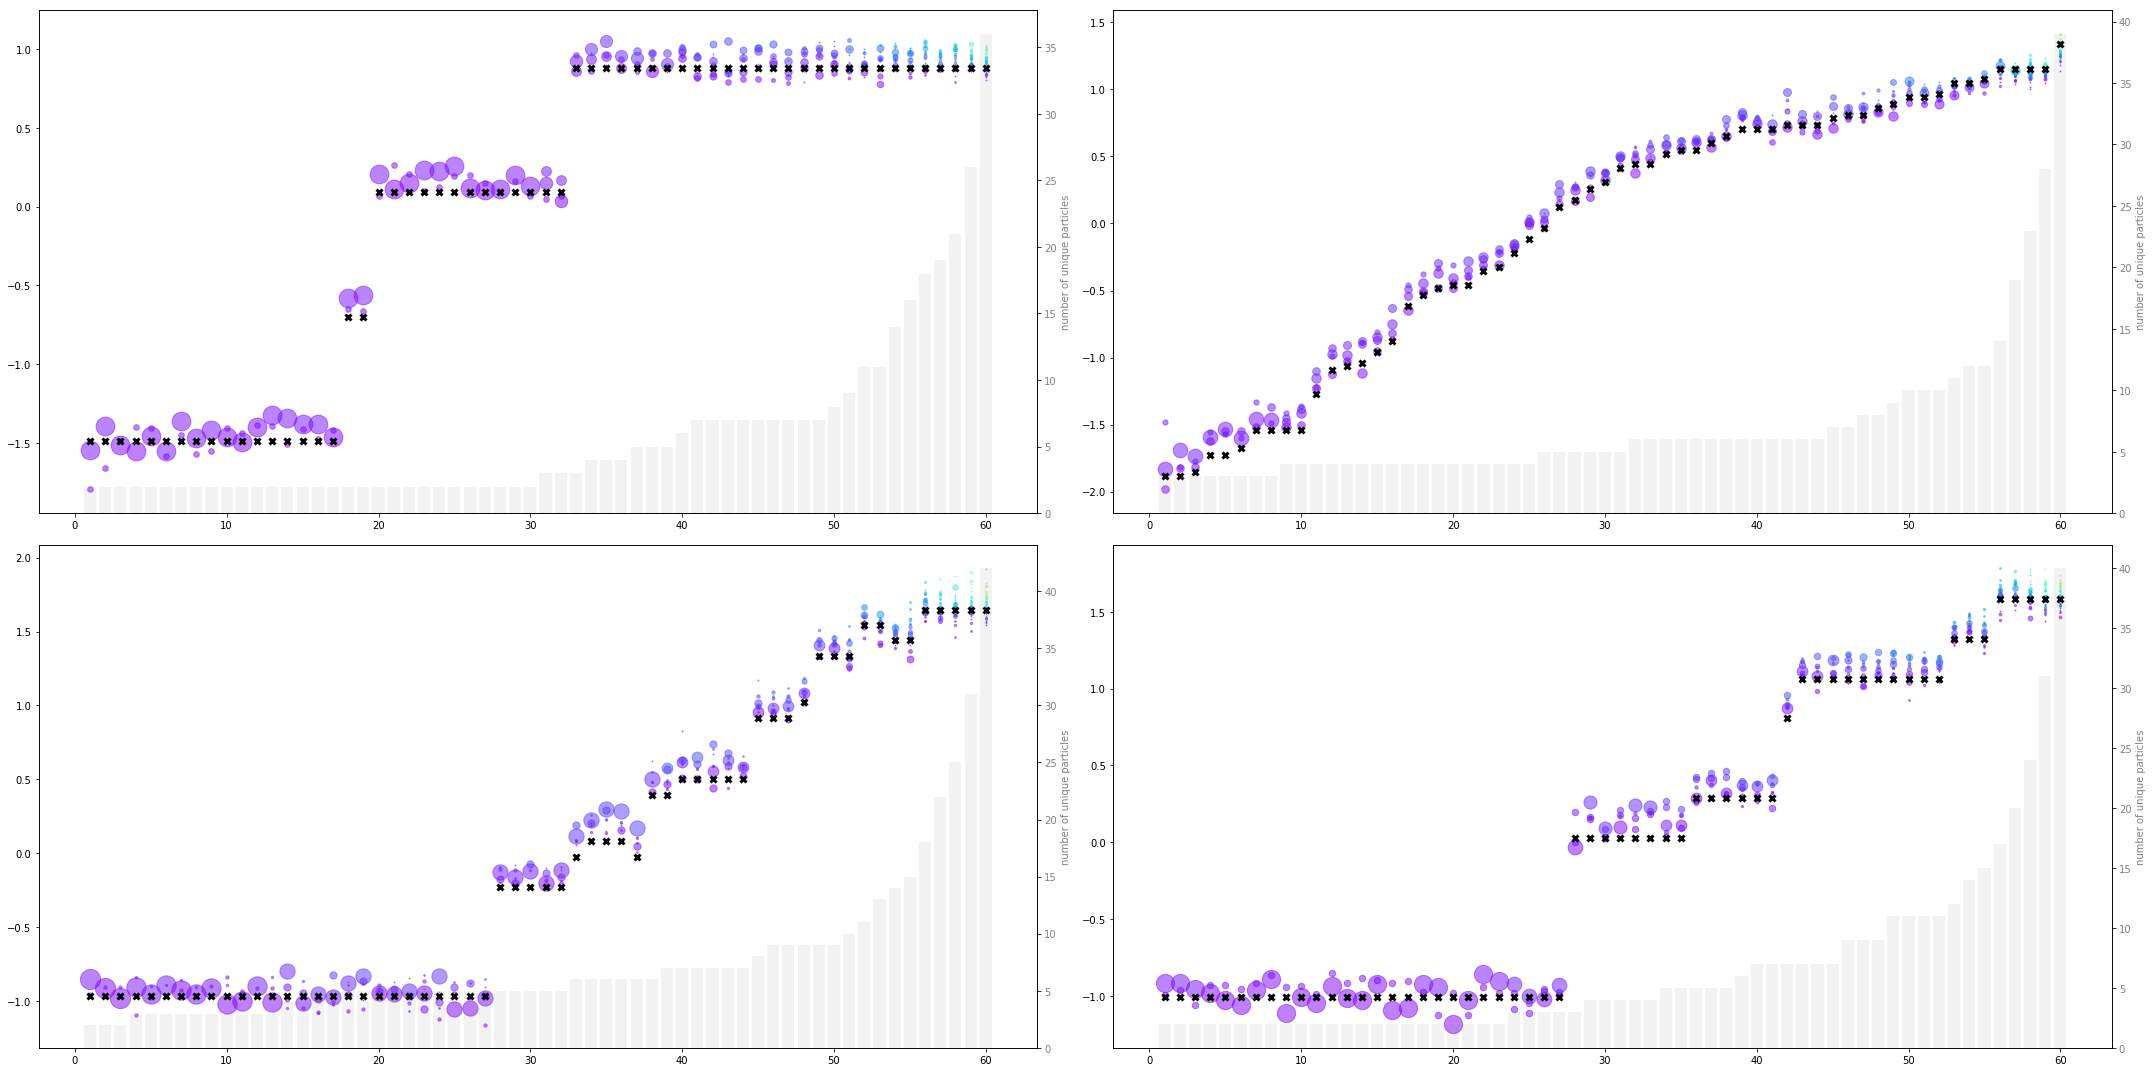

In [13]:
plot_resampled_particles_multiple(covid_preds_resampled, covid_truth)

In [19]:
#plot_resampled_particles(synthetic_1_preds_resampled, synthetic_truth, factor=3.5)